In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

import collections
import random
import re
from d2l import torch as d2l


import torchvision
from torchvision import transforms
import torchvision.models as models
from ptflops import get_model_complexity_info

import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [51]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state
    
    def forward(self, inputs, H=None):
        if H is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
        outputs = []
        for X in inputs:
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                            torch.matmul(H, self.W_hz) + self.b_z)
            R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                            torch.matmul(H, self.W_hr) + self.b_r)
            H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                            torch.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            outputs.append(H)
        return outputs, H


training time = 39.689178705215454
GRUScratch(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
Computational complexity:       0.0 Mac 
Number of parameters:           5.86 k  


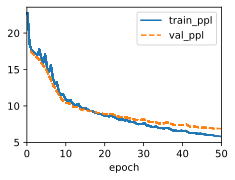

In [56]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
print(f'training time = {time.time()-t0}')
macs, params = get_model_complexity_info(gru,(1024,len(data.vocab)))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [57]:
model.predict('time is', 100,data.vocab,d2l.try_gpu())

'time is and the that in and the that in and the that in and the that in and the that in and the that in and'

In [37]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self,inputs,H_C=None):
        if H_C is None:
            H = torch.zeros((inputs.shape[1],self.num_hiddens),device=inputs.device)
            C = torch.zeros((inputs.shape[1],self.num_hiddens),device=inputs.device)
        else:
            H, C = H_C
        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X,self.W_xi) + torch.matmul(H,self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(X,self.W_xf) + torch.matmul(H,self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(X,self.W_xo) + torch.matmul(H,self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(X,self.W_xc) + torch.matmul(H,self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)

training time = 43.9381263256073
LSTMScratch(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
Computational complexity:       0.0 Mac 
Number of parameters:           7.81 k  


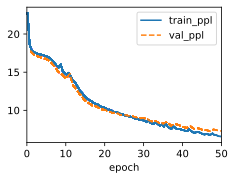

In [61]:
data = d2l.TimeMachine(batch_size=1024,num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens =32)
model = d2l.RNNLMScratch(lstm, vocab_size = len(data.vocab), lr = 4)
trainer = d2l.Trainer(max_epochs=50,gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
print(f'training time = {time.time()-t0}')

macs, params = get_model_complexity_info(lstm,(1024,len(data.vocab)))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [62]:
model.predict('time is', 100,data.vocab,d2l.try_gpu())

'time is the time the time the time the time the time the time the time the time the time the time the time '

In [8]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[LSTMScratch(
            num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                                    for i in range(num_layers)])

    def forward(self, inputs, Hs=None):
        outputs = inputs
        if Hs is None: Hs = [None] * self.num_layers
        for i in range(self.num_layers):
            outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
            outputs = torch.stack(outputs, 0)
        return outputs, Hs


training time = 119.08936643600464
StackedRNNScratch(
  0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
  (rnns): Sequential(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (0): LSTMScratch(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  )
)
Computational complexity:       0.0 Mac 
Number of parameters:           266.45 k


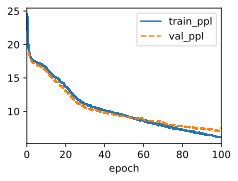

In [72]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),
                              num_hiddens=244, num_layers=1)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
print(f'training time = {time.time()-t0}')
macs, params = get_model_complexity_info(rnn_block,(1024,len(data.vocab)))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [77]:
model.predict('time', 100,data.vocab,d2l.try_gpu())

'timention a oure and the allered the expered the cealle and the allered the expered the cealle and the a'

In [11]:
class StackedRNNScratchG(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[GRUScratch(
            num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                                    for i in range(num_layers)])

    def forward(self, inputs, Hs=None):
        outputs = inputs
        if Hs is None: Hs = [None] * self.num_layers
        for i in range(self.num_layers):
            outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
            outputs = torch.stack(outputs, 0)
        return outputs, Hs


training time = 111.79319500923157
StackedRNNScratchG(
  0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
  (rnns): Sequential(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (0): GRUScratch(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  )
)
Computational complexity:       0.0 Mac 
Number of parameters:           199.84 k


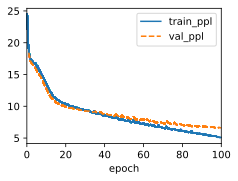

In [63]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratchG(num_inputs=len(data.vocab),
                              num_hiddens=244, num_layers=1)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
print(f'training time = {time.time()-t0}')

macs, params = get_model_complexity_info(rnn_block,(1024,len(data.vocab)))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [71]:
model.predict('time is', 100,data.vocab,d2l.try_gpu())

'time is a said the time traveller the the the the the the the the the the the the the the the the the the t'